# Preliminary Pulsar data analysis

In [30]:
library(tidyverse)
library(ggplot2)
library(dplyr) 
library(tidymodels)
install.packages("corrplot")
library(corrplot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

corrplot 0.92 loaded



## 1. import the data, tidy the data set, show summary statistics 

In [2]:
# import data
temp  <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip",temp)
pulsar <- read.csv(unz(temp, "HTRU_2.csv"), header = FALSE, 
                   col.names = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness",
                                 "Class"))

In [3]:
# dimension of the data set
dim(pulsar) 

[1] 17898     9

- 17898 observations (rows)
- 9 variables (columns)

In [4]:
head(pulsar)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
2,102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
3,103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
4,136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
5,88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
6,93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [6]:
# summary statistics for all 8 predictors
summary_table <- data.frame(cbind(summary(pulsar$integr.mean), summary(pulsar$integr.std),
                                  summary(pulsar$integr.kurtosis), summary(pulsar$integr.skewness),
                                  summary(pulsar$DMSNR.mean), summary(pulsar$DMSNR.std), 
                                  summary(pulsar$DMSNR.kurtosis), summary(pulsar$DMSNR.skewness))) 
colnames(summary_table) <- c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness")
summary_table

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,5.8125,24.77204,-1.87601118,-1.7918860,0.2132107,7.370432,-3.139270,-1.976976
1st Qu.,100.9297,42.37602,0.02709812,-0.1885717,1.9230769,14.437332,5.781506,34.960504
Median,115.0781,46.94748,0.22324002,0.1987104,2.8018395,18.461316,8.433515,83.064556
Mean,111.0800,46.54953,0.47785726,1.7702790,12.6143997,26.326515,8.303556,104.857709
3rd Qu.,127.0859,51.02320,0.47332518,0.9277831,5.4642559,28.428104,10.702959,139.309330
Max.,192.6172,98.77891,8.06952205,68.1016217,223.3921405,110.642211,34.539844,1191.000837


In [7]:
# check the missing data
sum(is.na(pulsar))

[1] 0

- no missing data here

In [8]:
# show number of observations in each class
count_data <- pulsar %>% group_by(Class) %>% summarise(n=n()) 
count_data 

Class,n
<int>,<int>
0,16259
1,1639


- `0 is the negative examples`
- `1 is the positive examples`
- majority of the data (around 90%) are in class 0

## 2. split the data into training and testing sets

In [9]:
set.seed(123)
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

In [10]:
# dimension of the training data set 
dim(pulsar_train) 

[1] 13423     9

In [11]:
# number of observations in each class
count_train <- pulsar_train %>% group_by(Class) %>% summarise(n=n()) # severe imbalanced training set
count_train

Class,n
<int>,<int>
0,12170
1,1253


Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



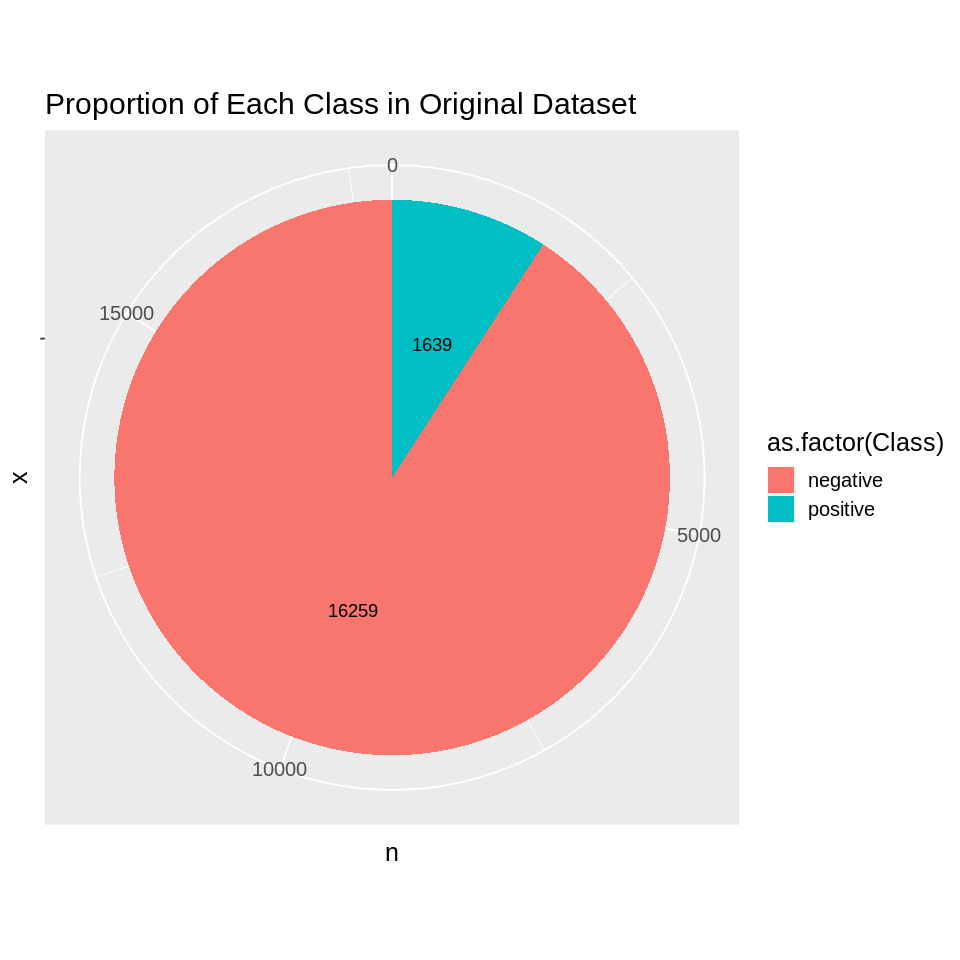

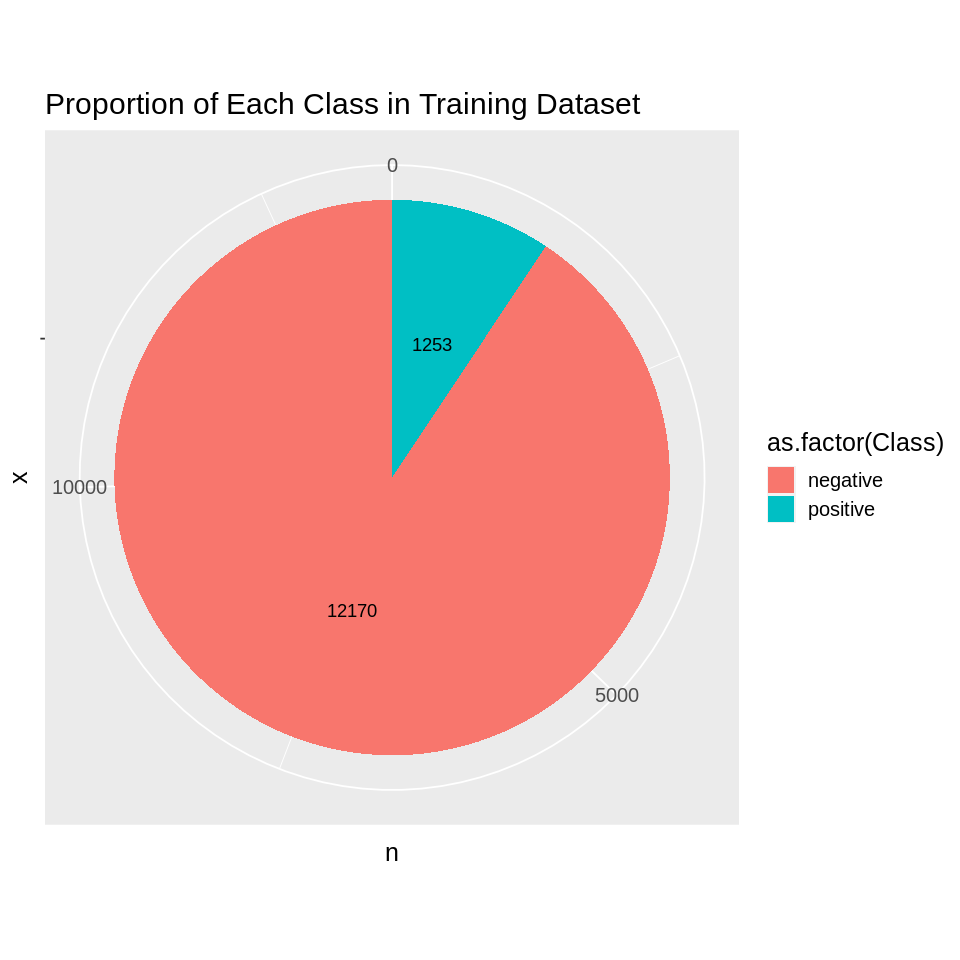

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8) 

ggplot(count_data, aes(x = "", y = n, fill = as.factor(Class))) +
  geom_bar(stat = "identity") + 
  geom_text(aes(label = n), position = position_stack(vjust = 0.5)) + 
  coord_polar(theta = "y", start = 0) + 
  scale_fill_brewer(palette = 'Pastel1') + 
  scale_fill_discrete(labels = c("negative", "positive")) + 
  ggtitle("Proportion of Each Class in Original Dataset") + 
  theme(text = element_text(size=15)) 

ggplot(count_train, aes(x = "", y = n, fill = as.factor(Class))) +
  geom_bar(stat = "identity") + 
  geom_text(aes(label = n), position = position_stack(vjust = 0.5)) + 
  coord_polar(theta = "y", start = 0) + 
  scale_fill_brewer(palette = 'Pastel1') + 
  scale_fill_discrete(labels = c("negative", "positive")) + 
  ggtitle("Proportion of Each Class in Training Dataset") + 
  theme(text = element_text(size=15)) 

- training data set show the same proportion as the original dataset

## 3. Sample down the `0 (negative) class` in the training set: to deal with the imbalancing probelm.
### - let the number of data belongs to class 0 = the number of data belongs to class 1
### - so that proportion for the two classes are the same, equals to 0.5

In [47]:
set.seed(123)
train_c1 <- filter(pulsar_train, Class == 1)
train_c0 <- filter(pulsar_train, Class == 0)

sample_down_train <- pulsar_train %>% 
  filter(Class ==0) %>%
  sample_n(nrow(train_c1)) %>%
  rbind(train_c1)

In [48]:
# dimension for the training data after sampling down
dim(sample_down_train)

[1] 2506    9

- 2506 observations
- 9 variables

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



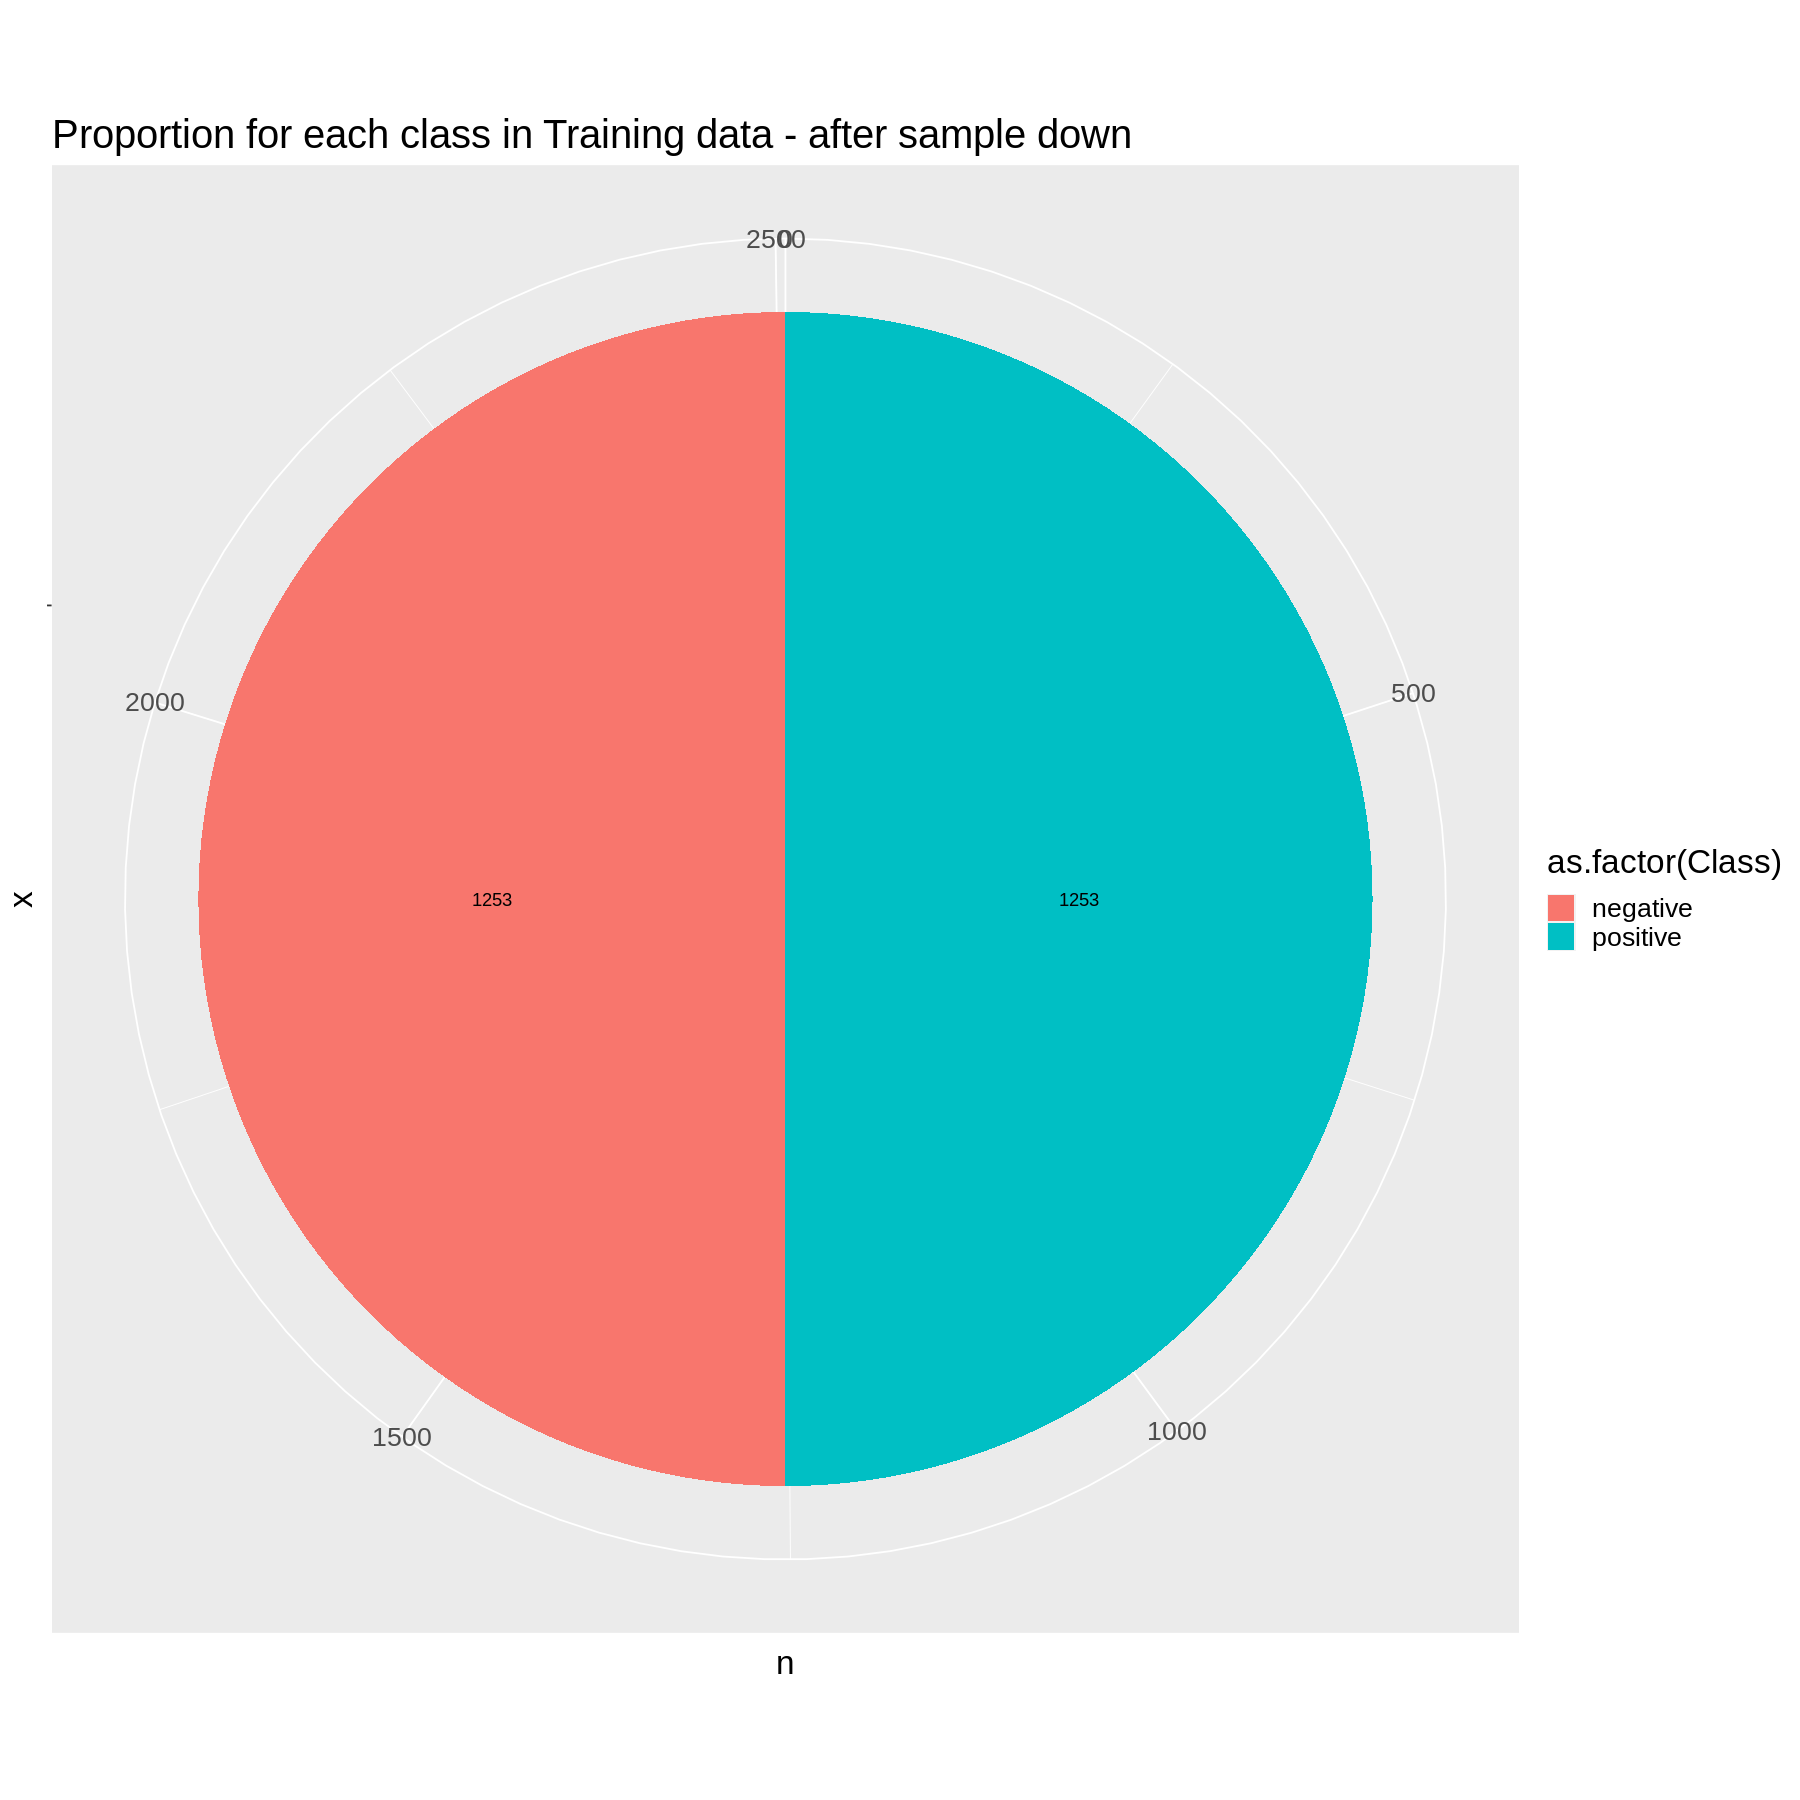

In [49]:
sample_down_train %>% 
  group_by(Class) %>% 
  summarise(n=n()) %>%
  ggplot(aes(x = "", y = n, fill = as.factor(Class))) +
  geom_bar(stat = "identity") + 
  geom_text(aes(label = n), position = position_stack(vjust = 0.5)) + 
  coord_polar(theta = "y", start = 0) + 
  scale_fill_brewer(palette = 'Pastel1') + 
  scale_fill_discrete(labels = c("negative", "positive")) + 
  ggtitle("Proportion for each class in Training data - after sample down") + 
  theme(text = element_text(size=20))

### use the training set after sampling down to do the analysis !

In [50]:
# calculate the means of the predictor variables
predictors_mean <- sample_down_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(predictors_mean) <- "mean"
predictors_mean

,mean
,<dbl>
integr.mean,86.256958
integr.std,42.861345
integr.kurtosis,1.700721
integr.skewness,8.177292
DMSNR.mean,29.887667
DMSNR.std,40.028187
DMSNR.kurtosis,5.824315
DMSNR.skewness,67.323829


#### large differences between the mean of these predictors:
the largest one is about 86, while the smallest one is only 1.7


## 4. Scale the training set after sampling down

In [52]:
all_predictors_name <- colnames(sample_down_train[, 1:8])

scaled_train <- sample_down_train %>% 
  mutate_at(all_predictors_name, ~(scale(.) %>% as.vector))


In [53]:
train_summary_table <- data.frame(cbind(summary(scaled_train$integr.mean), summary(scaled_train$integr.std),
                                  summary(scaled_train$integr.kurtosis), summary(scaled_train$integr.skewness),
                                  summary(scaled_train$DMSNR.mean), summary(scaled_train$DMSNR.std), 
                                  summary(scaled_train$DMSNR.kurtosis), summary(scaled_train$DMSNR.skewness))) 
colnames(train_summary_table) <- c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness")
train_summary_table

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Min.,-2.063690e+00,-2.167562e+00,-1.713450e+00,-7.536754e-01,-6.980701e-01,-1.310994e+00,-1.723480e+00,-6.851254e-01
1st Qu.,-8.460459e-01,-8.084394e-01,-7.530860e-01,-6.354165e-01,-6.467820e-01,-9.281084e-01,-8.585520e-01,-6.502978e-01
Median,2.374179e-01,4.664097e-02,-5.150877e-01,-5.389346e-01,-5.436098e-01,-3.045725e-01,-1.336230e-01,-3.934826e-01
Mean,1.698600e-16,3.169741e-16,1.794415e-17,-3.234156e-17,-1.430887e-17,-1.394447e-16,6.247955e-17,-9.230731e-18
3rd Qu.,8.099643e-01,7.350632e-01,6.425342e-01,2.861652e-01,2.393543e-01,9.147824e-01,6.931118e-01,3.099548e-01
Max.,2.539729e+00,4.905129e+00,3.173435e+00,4.711405e+00,4.163813e+00,2.722087e+00,5.372250e+00,9.950703e+00


In [54]:
scaled_predictors_mean <- scaled_train %>% 
  select(-Class) %>% 
  colMeans() %>%
  data.frame()
colnames(scaled_predictors_mean) <- "mean"
scaled_predictors_mean

,mean
,<dbl>
integr.mean,1.686572e-16
integr.std,3.168992e-16
integr.kurtosis,1.484137e-17
integr.skewness,-3.649426e-17
DMSNR.mean,-1.664808e-17
DMSNR.std,-1.331459e-16
DMSNR.kurtosis,5.974620e-17
DMSNR.skewness,-7.091184e-18


#### After scaling the predictos in thetraining set, every predictor has mean around 0.

In [55]:
head(scaled_train)

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,0.9530132,1.8106637,-0.8168831,-0.7010886,-0.6561685,-1.0755796,0.89087155,0.7126506,0
2,1.0886967,3.6593985,-0.8675785,-0.7536754,1.5101584,1.5944108,-1.15877415,-0.6803251,0
3,1.3450323,0.5883488,-1.0096455,-0.6209852,-0.6637171,-1.0960985,1.17488947,1.0446210,0
4,0.7439764,1.0821099,-0.6363887,-0.6296116,-0.3042426,0.5808810,-0.59015834,-0.5998106,0
5,0.8339644,-0.0828916,-0.6085113,-0.5989493,-0.5693893,-0.3795561,-0.00139643,-0.3265444,0
6,-0.1064005,-0.6559463,-0.4430658,-0.4385813,-0.6034269,-0.5059058,0.22646530,-0.1780283,0


## 5. visualize the training set

In [60]:
pivot_train <- scaled_train %>%
  pivot_longer(cols = integr.mean:DMSNR.skewness,
               names_to = "predictor", 
               values_to = "value")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



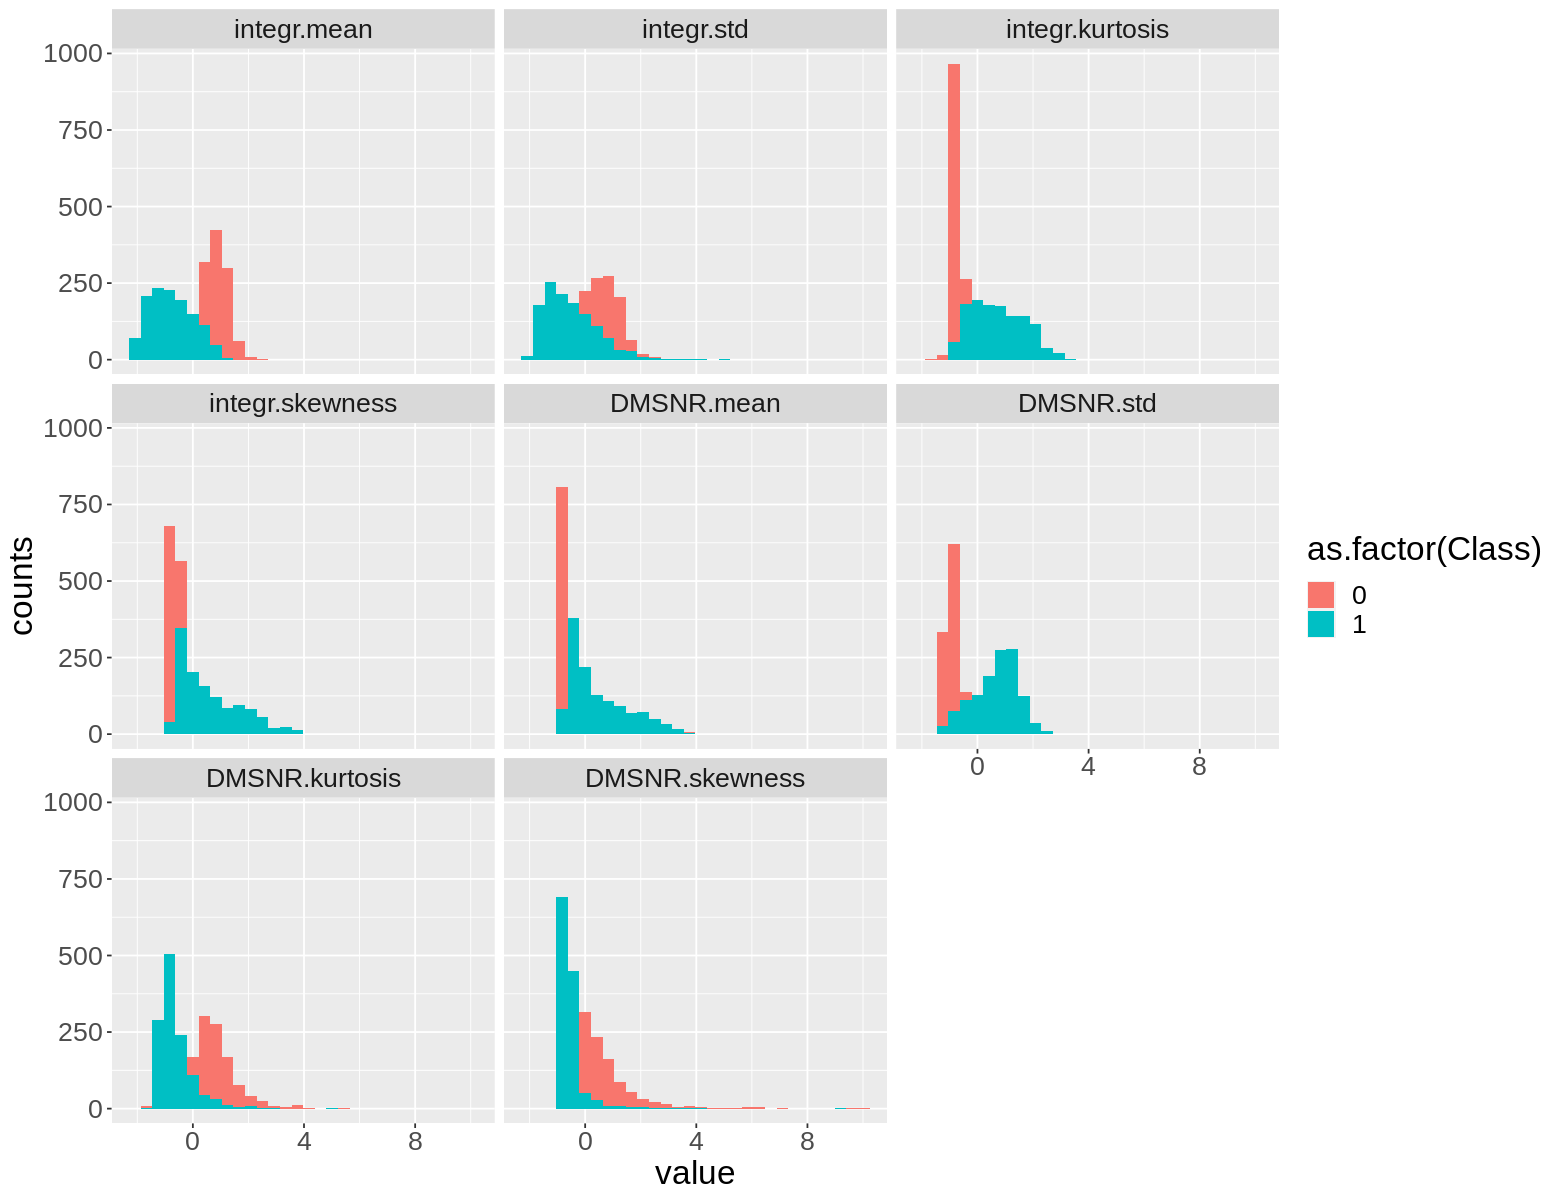

In [61]:
# histogram for all 8 variables
options(repr.plot.width = 13, repr.plot.height = 10) 

pivot_train %>% 
  ggplot(aes(x = value, fill = as.factor(Class))) + 
  geom_histogram(position = "identity") + 
  facet_wrap(~ factor(predictor, 
                      levels = c("integr.mean", "integr.std", "integr.kurtosis", "integr.skewness",
                                 "DMSNR.mean", "DMSNR.std", "DMSNR.kurtosis", "DMSNR.skewness"))) +
  xlab("value") + 
  ylab("counts") +
  theme(text = element_text(size=20)) 

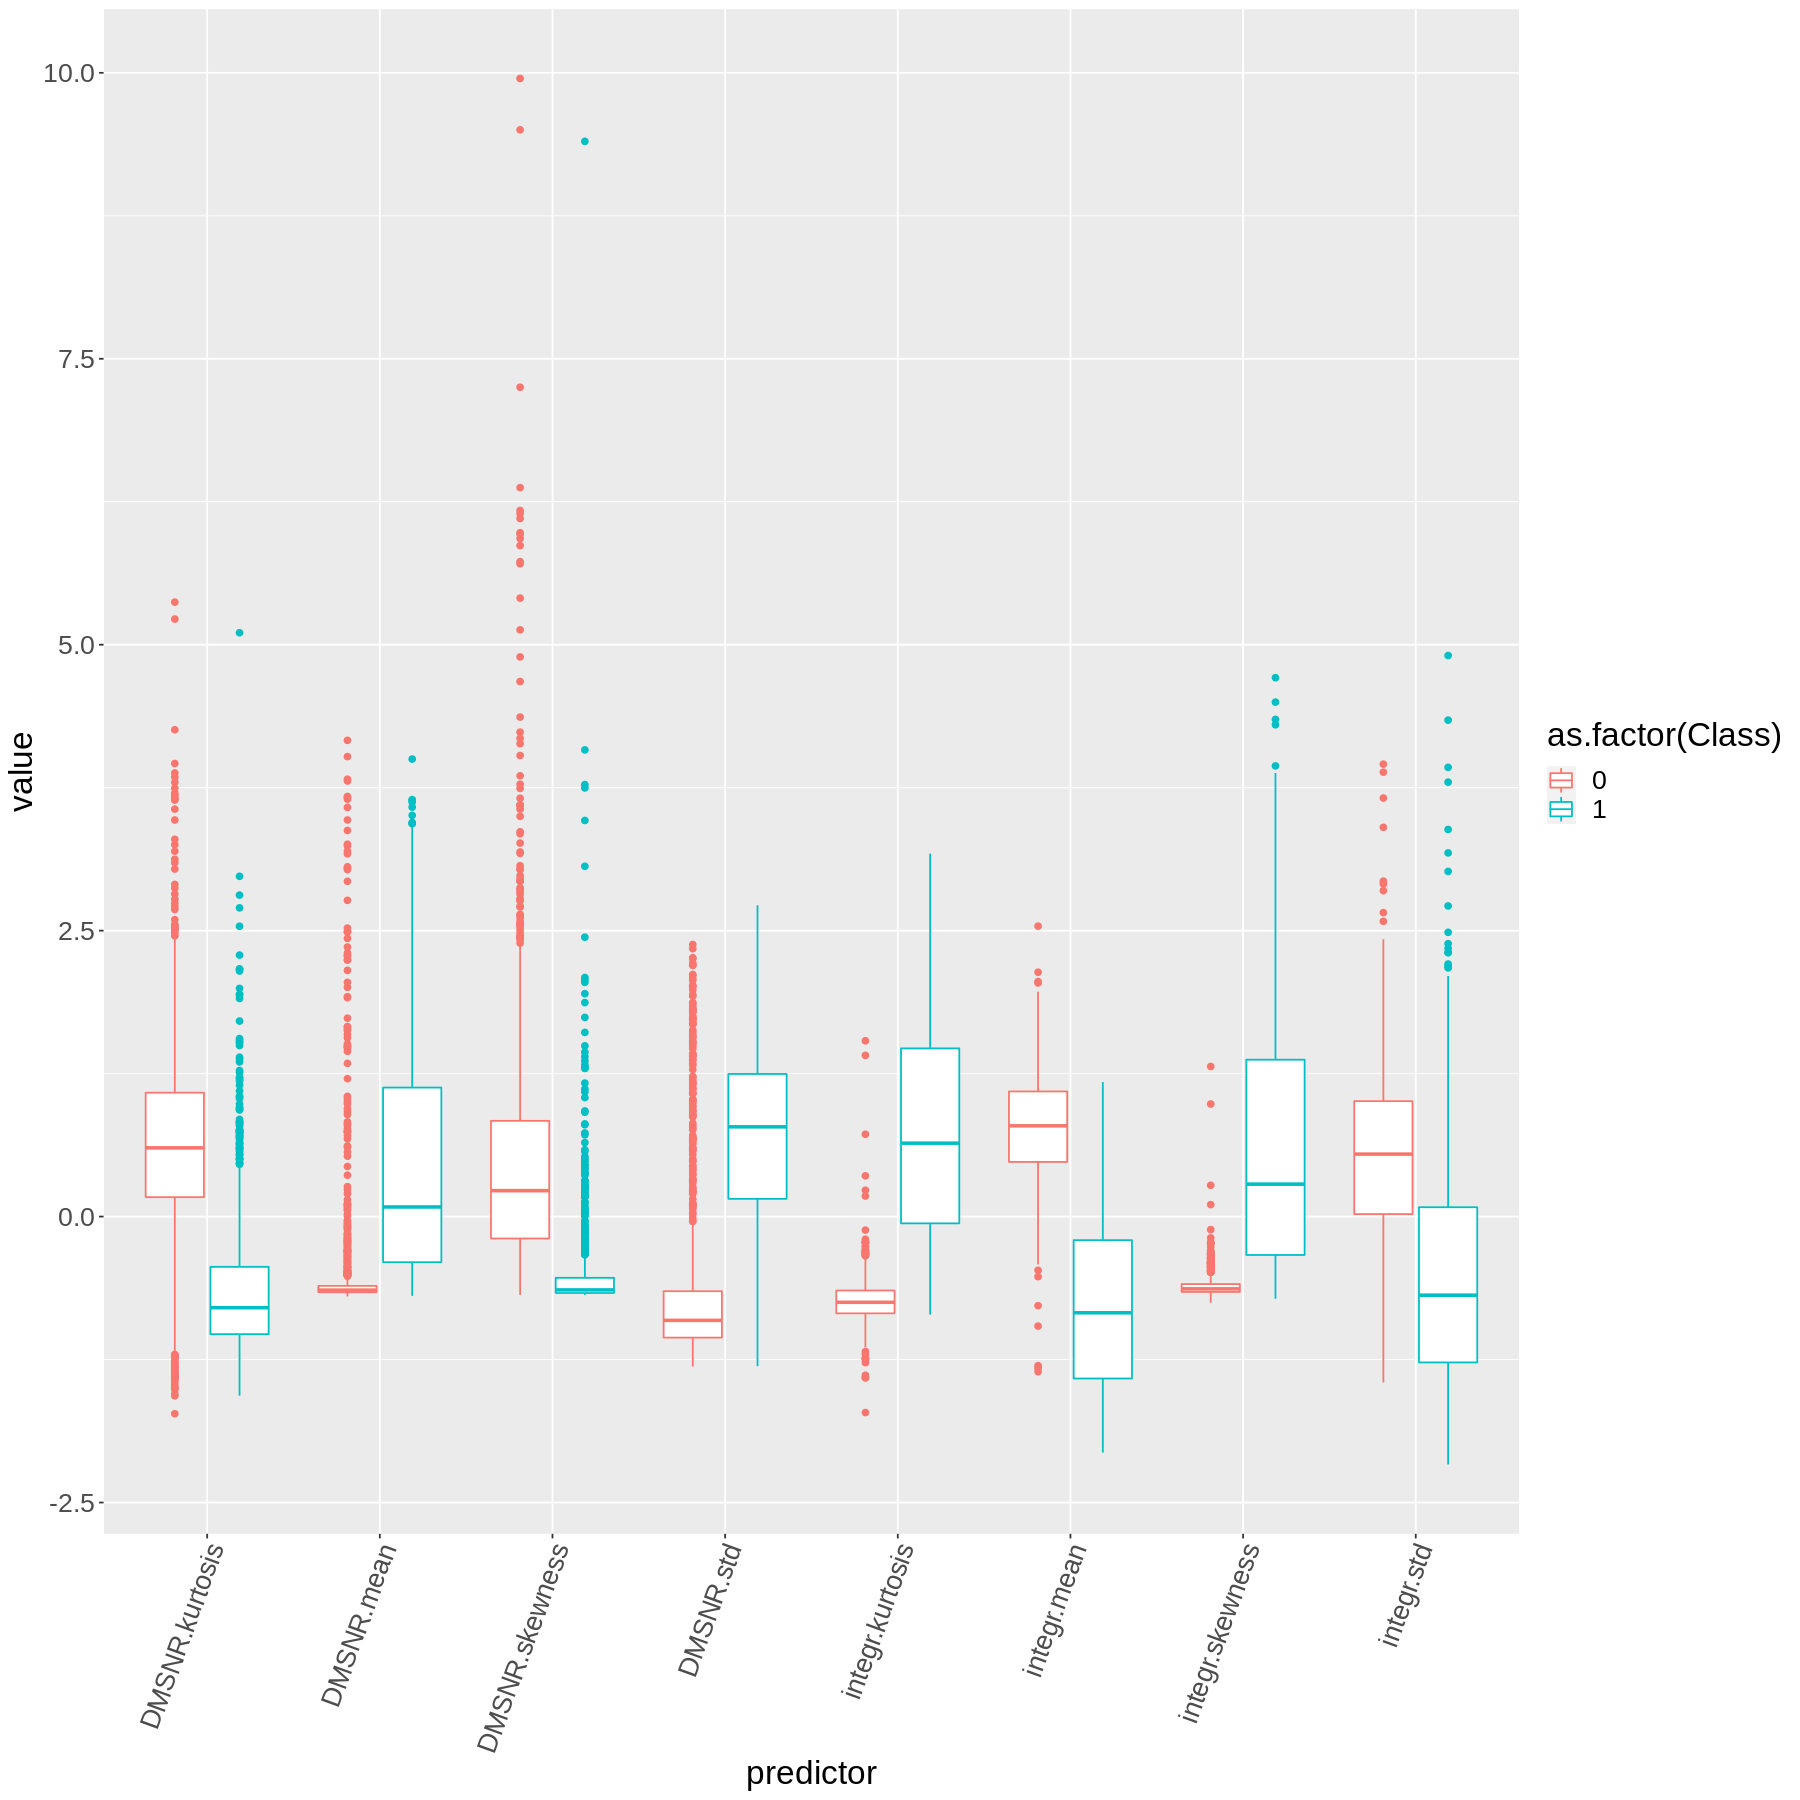

In [62]:
# boxplot
options(repr.plot.width = 15, repr.plot.height = 15) 
ggplot(pivot_train, aes(x=predictor, y=value, color = as.factor(Class))) + 
  geom_boxplot() + 
  theme(axis.text.x = element_text(angle = 70, hjust = 1),
        text = element_text(size=20)) 

##### Both histogram and Boxplot are used to explore the relationship between continuous variables and a categorical variable.
##### show the differences between the each category class
- `integr.kurtosis`, `integr.skewness`, `DMSNR.std`, `DMSNR.mean` predictors has larger mean in Class 1;
- `integr.mean`, `integr.std`, `DMSNR.kurtosis`, `DMSNR.skewness` predictors has larger mean in Class 0;

-  data from `DMSNR.skewness` in Class 0 has the most spread distribution;
- almost all predictors in both Classes show skewed to right distribution.

## 6. Choose of predictors

#### In the dataset, the Categorical variable Class `Class` has been tranformed into a `dummy variable`: has values equal to either 0 or 1.

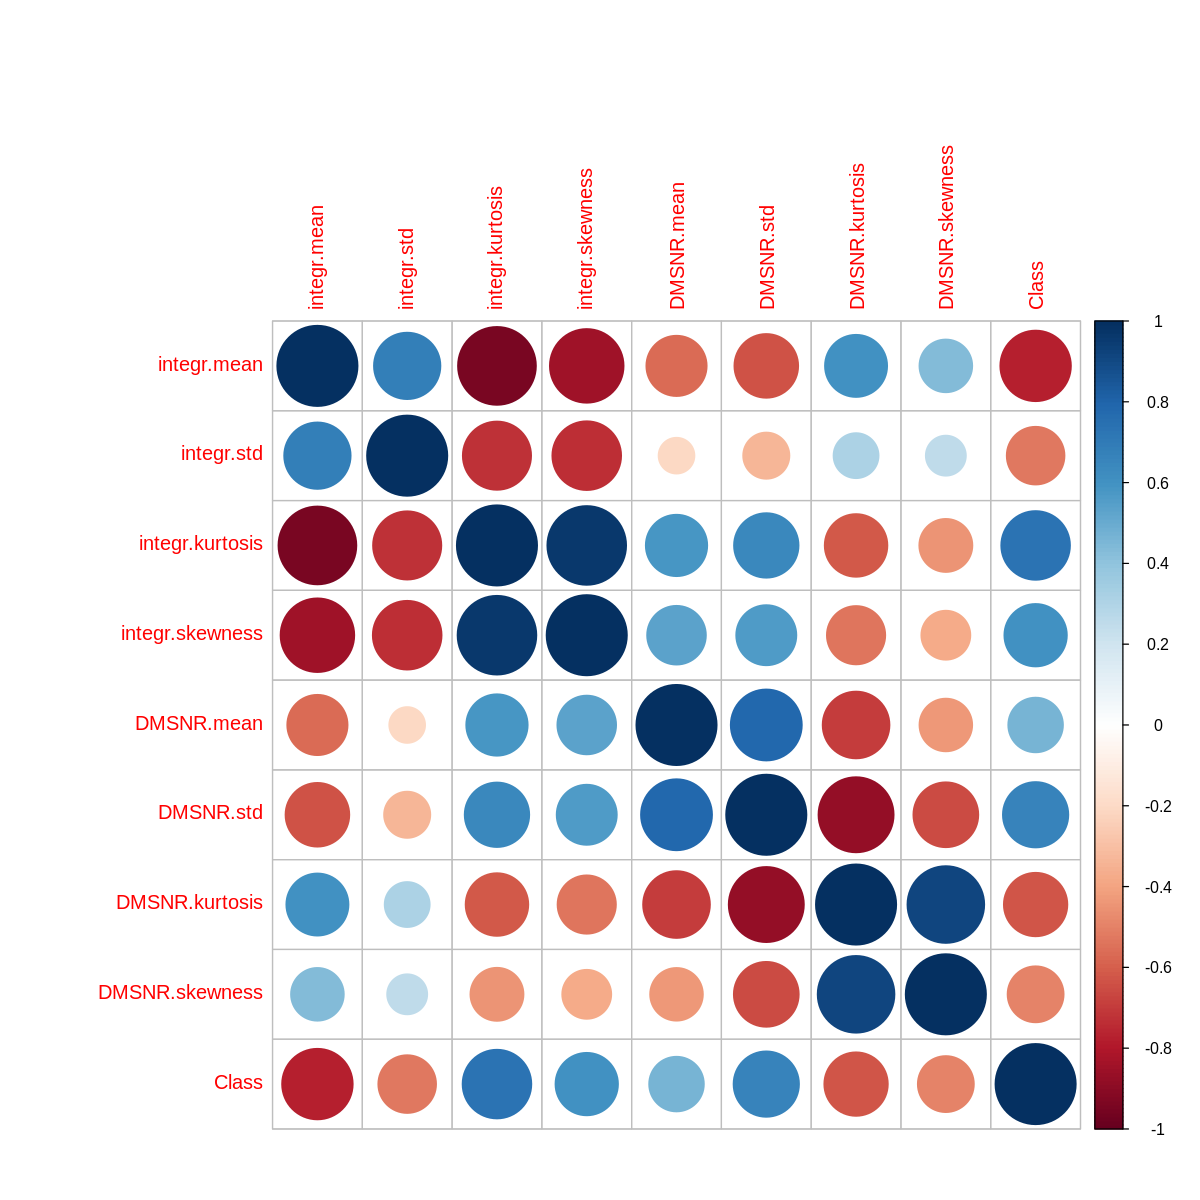

In [63]:
options(repr.plot.width = 10, repr.plot.height = 10) 
corrplot(cor(scaled_train))

In [64]:
corr.mat <- cor(scaled_train)
corr.mat
corr.mat[ , ncol(corr.mat), drop = FALSE] 

,integr.mean,integr.std,integr.kurtosis,integr.skewness,DMSNR.mean,DMSNR.std,DMSNR.kurtosis,DMSNR.skewness,Class
integr.mean,1.0000000,0.6872586,-0.9422078,-0.8437732,-0.5669821,-0.6332698,0.6017493,0.4353288,-0.7750963
integr.std,0.6872586,1.0000000,-0.7253721,-0.7359978,-0.2027974,-0.3349863,0.3179430,0.2526690,-0.5205059
integr.kurtosis,-0.9422078,-0.7253721,1.0000000,0.9632965,0.5881824,0.6483486,-0.6119384,-0.4403267,0.7349228
integr.skewness,-0.8437732,-0.7359978,0.9632965,1.0000000,0.5384755,0.5636006,-0.5311853,-0.3762123,0.6084140
DMSNR.mean,-0.5669821,-0.2027974,0.5881824,0.5384755,1.0000000,0.7846939,-0.6949288,-0.4344707,0.4673093
DMSNR.std,-0.6332698,-0.3349863,0.6483486,0.5636006,0.7846939,1.0000000,-0.8769701,-0.6560657,0.6662586
DMSNR.kurtosis,0.6017493,0.3179430,-0.6119384,-0.5311853,-0.6949288,-0.8769701,1.0000000,0.9151934,-0.6282438
DMSNR.skewness,0.4353288,0.2526690,-0.4403267,-0.3762123,-0.4344707,-0.6560657,0.9151934,1.0000000,-0.4900915
Class,-0.7750963,-0.5205059,0.7349228,0.6084140,0.4673093,0.6662586,-0.6282438,-0.4900915,1.0000000


,Class
integr.mean,-0.7750963
integr.std,-0.5205059
integr.kurtosis,0.7349228
integr.skewness,0.6084140
DMSNR.mean,0.4673093
DMSNR.std,0.6662586
DMSNR.kurtosis,-0.6282438
DMSNR.skewness,-0.4900915
Class,1.0000000


##### By looking at the last column of the correlation matrix, 
##### find `integr.mean`, `integr.kurtosis` are the most correlated predictors to `Class`, 
##### the absolute value of their correlation with `Class` are the largest;
##### and then are the `DMSNR.std`, `DMSNR.kurtosis`, `integr.skewness` predictors.

### Thus, we will use the 5 predictors to do the classification analysis
`integr.mean`, `integr.kurtosis`, `DMSNR.std`, `DMSNR.kurtosis`, `integr.skewness` 